# Домашнее задание №4. Convolutional neural network (CNN)

In [2]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# обучение и валидация модели
def train_eval_model(net, num_epochs, train_loader, valid_loader):
    for epoch in range(num_epochs):  
        net.train()
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обучение
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if i % 300 == 0:    # печатаем каждые 300 mini-batches
                net.eval()

                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}. ' \
                      f'Acc: {running_right / running_items:.3f}', end='. ')
                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(valid_loader):

                    test_outputs = net(data[0].to(device))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

                print(f'Test acc: {test_running_right / test_running_total:.3f}')

    print('Training is finished!')

## Задание

1. Обучите CNN (самописная) на CIFAR-100.

2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

3*.Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

## План работы

[0. Загрузка данных](#section_0)

[1. Dataset и Dataloader](#section_1)

[2. Самописная CNN](#section_2)

[3. Дообученная ImageNet Resnet-50](#section_3)

[4*. Дообученная ImageNet Resnet-50 с аугментацией](#section_4)

## 0. Загрузка данных<a id='section_0'></a>

In [5]:
# загружаем датасет
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

dataset = datasets.CIFAR100(root='data/',
                            train=True, 
                            download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [6]:
classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm')

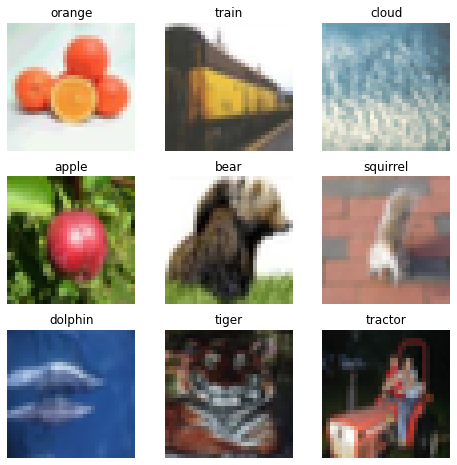

In [7]:
#просматриваем датасет
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

## 1. Dataset и Dataloader <a id='section_1'></a>

In [8]:
# разбиваем на train и tst
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

#класс датасета
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]  #извлекаем картинку
        if self.transform is not None:
            img = self.transform(img)
        label = self._base_dataset[idx][1] #извлекаем класс
        return img, label

#преобразования датасета
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

In [9]:
#разбиваем датасет
train_dataset, valid_dataset = train_valid_split(dataset)

#формируем экземпляры классов (тензор, класс)
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())
print('Количество экземплятор в тренировочном датасете: ', len(train_dataset))
print('Количество экземплятор в валидационном датасете: ', len(valid_dataset))

#итераторы для работы с датасетом
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

Количество экземплятор в тренировочном датасете:  47500
Количество экземплятор в валидационном датасете:  2500


In [10]:
#тензоры и классы
# один объект в train_loader -- это
#батч 128 из тензора размера (3,32,32), 128 меток классов
train_features, train_labels = next(iter(train_loader))
print(train_features.shape, train_labels.shape)
train_features, train_labels

torch.Size([128, 3, 32, 32]) torch.Size([128])


(tensor([[[[0.4235, 0.4275, 0.4314,  ..., 0.3882, 0.3765, 0.4549],
           [0.4353, 0.4392, 0.4431,  ..., 0.4314, 0.4275, 0.4824],
           [0.4510, 0.4549, 0.4627,  ..., 0.4863, 0.4863, 0.5020],
           ...,
           [0.5137, 0.5137, 0.4588,  ..., 0.3725, 0.3294, 0.3294],
           [0.5647, 0.5922, 0.5176,  ..., 0.3961, 0.3451, 0.3294],
           [0.6118, 0.6118, 0.5333,  ..., 0.4431, 0.3882, 0.3647]],
 
          [[0.6196, 0.6275, 0.6314,  ..., 0.5804, 0.5569, 0.6235],
           [0.6353, 0.6392, 0.6431,  ..., 0.6275, 0.6196, 0.6667],
           [0.6549, 0.6549, 0.6627,  ..., 0.6824, 0.6824, 0.6980],
           ...,
           [0.5255, 0.5373, 0.4941,  ..., 0.4196, 0.3804, 0.3765],
           [0.5608, 0.6039, 0.5451,  ..., 0.4157, 0.3725, 0.3569],
           [0.5961, 0.6157, 0.5529,  ..., 0.4118, 0.3686, 0.3490]],
 
          [[0.8784, 0.8863, 0.8941,  ..., 0.7843, 0.7490, 0.8078],
           [0.8941, 0.8980, 0.9059,  ..., 0.8353, 0.8118, 0.8549],
           [0.9137, 0.91

## 2. Самописная CNN <a id='section_2'></a>

In [11]:
torch.manual_seed(10)

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60) 
        self.conv_two = torch.nn.Conv2d(60, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 240, 3)
        self.bn_four = torch.nn.BatchNorm2d(240)
        self.fc1 = torch.nn.Linear(960, 400)
        self.out = torch.nn.Linear(400, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        return self.out(x)

In [13]:
# инициализация модели
net = Net().to(device)
#print(net)

In [14]:
# компиляция модели
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [15]:
# обучение модели
num_epochs = 10
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/10]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.007
Epoch [1/10]. Step [301/372]. Loss: 0.032. Acc: 0.068. Test acc: 0.120
Epoch [2/10]. Step [1/372]. Loss: 0.074. Acc: 0.055. Test acc: 0.081
Epoch [2/10]. Step [301/372]. Loss: 0.028. Acc: 0.146. Test acc: 0.176
Epoch [3/10]. Step [1/372]. Loss: 0.043. Acc: 0.141. Test acc: 0.128
Epoch [3/10]. Step [301/372]. Loss: 0.026. Acc: 0.194. Test acc: 0.198
Epoch [4/10]. Step [1/372]. Loss: 0.044. Acc: 0.133. Test acc: 0.202
Epoch [4/10]. Step [301/372]. Loss: 0.025. Acc: 0.228. Test acc: 0.219
Epoch [5/10]. Step [1/372]. Loss: 0.042. Acc: 0.156. Test acc: 0.244
Epoch [5/10]. Step [301/372]. Loss: 0.024. Acc: 0.257. Test acc: 0.217
Epoch [6/10]. Step [1/372]. Loss: 0.045. Acc: 0.156. Test acc: 0.262
Epoch [6/10]. Step [301/372]. Loss: 0.023. Acc: 0.281. Test acc: 0.238
Epoch [7/10]. Step [1/372]. Loss: 0.038. Acc: 0.172. Test acc: 0.236
Epoch [7/10]. Step [301/372]. Loss: 0.022. Acc: 0.298. Test acc: 0.263
Epoch [8/10]. Step [

**Вывод:** качество модели низкое, присутствует переобучение.

## 3. Дообученная ImageNet Resnet-50 <a id='section_3'></a>

In [16]:
# загрузка предобученной модели resnet50
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# все веса модели обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end = ', ')

True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
# замораживаем все слои предобученной модели
set_parameter_requires_grad(resnet50, True)

# теперь все веса модели не обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [20]:
#переопределяем последний слой сети
resnet50.fc = nn.Linear(2048, 100)

# все веса модели, кроме последнего, не обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [21]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
resnet50 = resnet50.to(device)

In [23]:
# преобразование признаков
trans_actions = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    # нормализация тензора со средним значением и стандартным отклонением (для каждого из 3 каналов)
                                    # output[channel] = (input[channel] - mean[channel]) / std[channel]
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                                    ])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

# разделение датасета на train и test
train_dataset, valid_dataset = train_valid_split(dataset)

# создание элементов класса датасета
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

# загрузчики датасетов
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [24]:
# список весов для обновления
params_to_update = []

# собираем рапаметры (веса), у которых param.requires_grad == True
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

params_to_update

[Parameter containing:
 tensor([[ 0.0063, -0.0154,  0.0143,  ..., -0.0171, -0.0166,  0.0164],
         [-0.0007, -0.0035,  0.0040,  ...,  0.0068, -0.0170, -0.0170],
         [-0.0154,  0.0212,  0.0190,  ...,  0.0019,  0.0067,  0.0018],
         ...,
         [-0.0113, -0.0159, -0.0127,  ...,  0.0004, -0.0203,  0.0087],
         [-0.0204, -0.0211, -0.0142,  ..., -0.0114, -0.0057, -0.0182],
         [-0.0198,  0.0117,  0.0127,  ...,  0.0219, -0.0002, -0.0111]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 5.7647e-03,  1.3104e-02,  5.7125e-03,  1.9547e-02,  5.8326e-03,
          1.5394e-02, -1.2468e-03,  4.8353e-03, -2.4460e-03,  2.0691e-02,
         -2.0554e-02, -6.7640e-05, -1.9148e-02, -2.1386e-03, -9.3640e-03,
         -1.6273e-03, -1.1885e-02,  9.9964e-03,  2.0058e-02,  1.2120e-02,
          2.3649e-03,  1.5900e-02, -1.8914e-03, -1.8180e-02,  2.0851e-02,
         -5.4445e-03, -1.5585e-02,  1.9667e-02, -1.7508e-02, -2.1082e-02,
          5.8144e-03, -1

In [25]:
# компиляция модели
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
num_epochs = 5
net = resnet50
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/5]. Step [1/372]. Loss: 0.037. Acc: 0.008. Test acc: 0.012
Epoch [1/5]. Step [301/372]. Loss: 0.014. Acc: 0.556. Test acc: 0.233
Epoch [2/5]. Step [1/372]. Loss: 0.023. Acc: 0.289. Test acc: 0.236
Epoch [2/5]. Step [301/372]. Loss: 0.008. Acc: 0.690. Test acc: 0.240
Epoch [3/5]. Step [1/372]. Loss: 0.022. Acc: 0.258. Test acc: 0.232
Epoch [3/5]. Step [301/372]. Loss: 0.007. Acc: 0.722. Test acc: 0.236
Epoch [4/5]. Step [1/372]. Loss: 0.021. Acc: 0.359. Test acc: 0.222
Epoch [4/5]. Step [301/372]. Loss: 0.007. Acc: 0.740. Test acc: 0.231
Epoch [5/5]. Step [1/372]. Loss: 0.019. Acc: 0.352. Test acc: 0.220
Epoch [5/5]. Step [301/372]. Loss: 0.006. Acc: 0.753. Test acc: 0.217
Training is finished!


**Вывод:** модель сильно переобучена, метрика на тесте меньше, чем у самописной модели.

## 4*. Дообученная ImageNet Resnet-50 с аугментацией <a id='section_4'></a>

In [25]:
# загрузка предобученной модели resnet50
resnet50_aug = models.resnet50(pretrained=True)

print(resnet50_aug)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# замораживаем все слои предобученной модели
set_parameter_requires_grad(resnet50_aug, True)

In [27]:
#переопределяем последний слой сети
resnet50_aug.fc = nn.Linear(2048, 100)

# все веса модели, кроме последнего, не обучаемы
for param in resnet50_aug.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [28]:
print(resnet50_aug)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
resnet50_aug= resnet50_aug.to(device)

In [30]:
# преобразование признаков
trans_actions = transforms.Compose([
                                   # аугментация (увеличение количества данных путем модификации имеющихся)
                                    #transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                    # изменение размеров изображения на (256,256)
                                    transforms.Resize(256),
                                    # поворот изображения на 90*
                                    transforms.RandomRotation(degrees=90),
                                    # произвольное изменение яркости и контрастности
                                    transforms.ColorJitter(brightness=2, contrast=2),
                                    # создаем обрезку (224,224) в случайном месте
                                    transforms.CenterCrop(224),
                                    # преобразуем изображение в тензор с значениеями от 0 до 1
                                    transforms.ToTensor(),
                                    # нормализация тензора со средним значением и стандартным отклонением (для каждого из 3 каналов)
                                    # output[channel] = (input[channel] - mean[channel]) / std[channel]
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                                    ])


valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

# разделение датасета на train и test
train_dataset, valid_dataset = train_valid_split(dataset)

# создание элементов класса датасета
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

# загрузчики датасетов
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [31]:
# список весов для обновления
params_to_update = []

# собираем рапаметры (веса), у которых param.requires_grad == True
for name, param in resnet50_aug.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

params_to_update

[Parameter containing:
 tensor([[-0.0017, -0.0096, -0.0050,  ...,  0.0084, -0.0003, -0.0004],
         [ 0.0083, -0.0110, -0.0055,  ..., -0.0161,  0.0151,  0.0090],
         [-0.0048, -0.0100,  0.0058,  ..., -0.0076, -0.0018,  0.0088],
         ...,
         [-0.0009, -0.0014,  0.0004,  ..., -0.0216, -0.0175, -0.0188],
         [-0.0197, -0.0215,  0.0032,  ...,  0.0164,  0.0033,  0.0044],
         [-0.0028, -0.0140,  0.0109,  ...,  0.0151,  0.0064,  0.0094]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-5.2021e-04,  8.7875e-03, -2.1865e-02, -2.0429e-02, -1.5326e-02,
          1.6641e-02, -5.1993e-03, -7.7514e-03,  1.4984e-02,  5.1485e-03,
          1.3592e-02, -1.4459e-02,  1.9841e-02,  7.8906e-03,  6.6262e-04,
          3.6759e-03,  1.0191e-02,  1.9985e-02, -1.0956e-02,  1.3765e-02,
          1.3383e-02,  1.0093e-02,  1.9153e-02, -1.9062e-02, -1.4593e-02,
          2.0353e-02,  7.1293e-03,  1.8359e-02, -2.1899e-02, -8.7423e-03,
          6.0026e-03, -4

In [32]:
# компиляция модели
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [33]:
num_epochs = 5
net = resnet50_aug
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.023. Test acc: 0.016
Epoch [1/5]. Step [301/372]. Loss: 0.028. Acc: 0.173. Test acc: 0.202
Epoch [2/5]. Step [1/372]. Loss: 0.031. Acc: 0.188. Test acc: 0.207
Epoch [2/5]. Step [301/372]. Loss: 0.024. Acc: 0.265. Test acc: 0.215
Epoch [3/5]. Step [1/372]. Loss: 0.029. Acc: 0.188. Test acc: 0.208
Epoch [3/5]. Step [301/372]. Loss: 0.023. Acc: 0.286. Test acc: 0.210
Epoch [4/5]. Step [1/372]. Loss: 0.032. Acc: 0.188. Test acc: 0.190
Epoch [4/5]. Step [301/372]. Loss: 0.023. Acc: 0.296. Test acc: 0.196
Epoch [5/5]. Step [1/372]. Loss: 0.030. Acc: 0.141. Test acc: 0.194
Epoch [5/5]. Step [301/372]. Loss: 0.022. Acc: 0.301. Test acc: 0.190
Training is finished!


**Вывод:** метрика меньше, чем до применения аугментации. Зато модель не так сильно переобучена.